# Import the necessary libraries and load the dataframes required for this analysis

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import Preprocessing as pp
import textwrap

from matplotlib.colors import LinearSegmentedColormap, to_hex, Normalize
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
data = pp.load_all_data()

df_all = data["df_all"]
df_all_items = data["df_all_items"]
df_food = data["df_food"]
df_housing_energy = data["df_housing_energy"]
df_transport = data["df_transport"]
df_weights = data["df_weights"]

c:\Mambaforge\envs\ecaf_tools\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Mambaforge\envs\ecaf_tools\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Mambaforge\envs\ecaf_tools\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Mambaforge\envs\ecaf_tools\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Mambaforge\envs\ecaf_tools\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserW

# III.	Analysis of the 2021 Inflation Surge

## III.1. Evolution of the HICP index over time

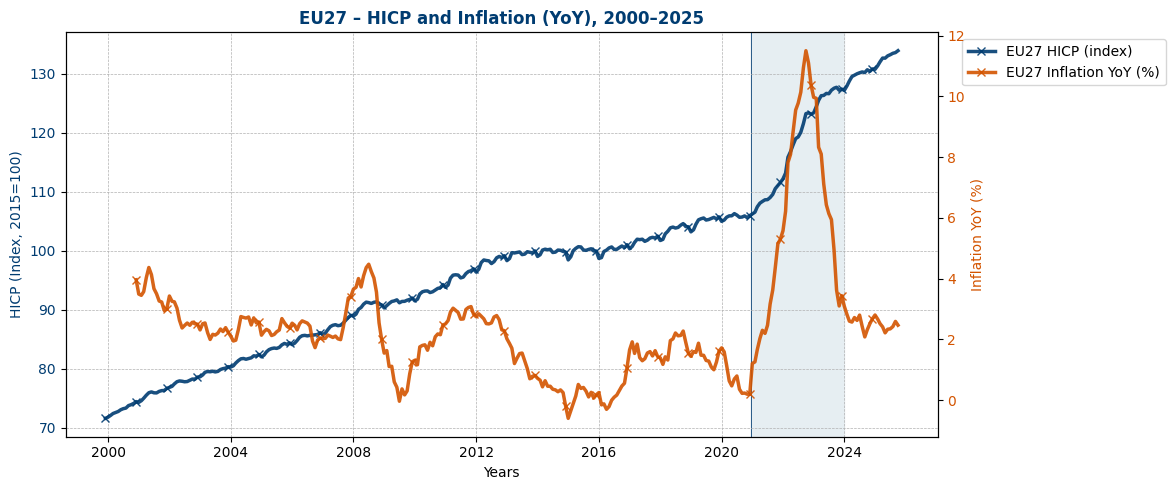

In [3]:
# Initialize the figure and axes layout
fig, ax = plt.subplots(figsize=(14, 5))

# 1. Data Preparation
# First, I sort the dataset by Country and Date to ensure the time-series structure 
# is correct before performing any lag calculations.
df_all = df_all.sort_values(["Country", "Date"])

# I calculate the Year-on-Year (YoY) inflation rate.
# group by 'Country' and 'label' (category) to ensure the percentage change 
# is calculated distinctively within each specific time series. 
# A period of 12 implies a comparison with the same month of the previous year.
df_all['inflation_yoy'] = (
    df_all.groupby(['Country','label'])['HICP']
          .pct_change(periods=12) * 100
)

# 2. Filtering for the Aggregate View
# I want to plot the trajectory of the entire European Union first to get a high-level overview.
EU_NAME = 'European Union - 27 countries (from 2020)'

# I filter the dataset to retain only the 'All-items HICP' index for the EU27 aggregate.
data_eu = df_all.loc[
    (df_all['Country'] == EU_NAME) & 
    (df_all['label'] == "All-items HICP")
]

# 3. Dual-Axis Plotting
# I need two axes: one for the inflation trend and the other for the HICP index, 
# allowing me to superimpose the rate of change on top of the price levels.

# --- Primary Axis (Left): HICP Index Level ---
# I plot the absolute HICP index values over time using the institutional dark blue.
line_hicp, = ax.plot(
    data_eu["Date"],
    data_eu["HICP"],
    label="EU27 HICP (index)",
    color="#003C71",  
    marker="x",
    markevery=12,    
    linewidth=2.5,
    alpha=0.9,
    zorder=5
)

# Format the primary axis
ax.set_xlabel("Years", color='black')
ax.set_ylabel("HICP (Index, 2015=100)", color="#003C71")
ax.tick_params(axis='y', labelcolor="#003C71")
ax.grid(True, linestyle='--', linewidth=0.5)

# --- Secondary Axis (Right): Inflation Rate ---
# I instantiate a twin axis to share the same x-axis (Date) but with a different scale.
ax2 = ax.twinx()

# I plot the calculated YoY Inflation rate using a contrasting orange to highlight the trend.
line_inflation, = ax2.plot(
    data_eu["Date"],
    data_eu["inflation_yoy"],
    label="EU27 Inflation YoY (%)",
    color="#D35400",  
    marker="x",
    markevery=12,
    linewidth=2.5,
    alpha=0.9,
    zorder=6
)

# Format the secondary axis
ax2.set_ylabel("Inflation YoY (%)", color="#D35400")
ax2.tick_params(axis='y', labelcolor="#D35400")

# 4. Legend & Annotation
# Since I have two axes, I manually consolidate the legends into a single box for clarity.
lines = [line_hicp, line_inflation]
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.02, 1))

# Highlight the structural break.
# I add a vertical line to visually mark the start of 2021 (the regime shift).
ax.axvline(x=pd.to_datetime("2021/01/01"), color='#003C71', zorder=0)

# I also add a shaded background covering the 2021-2024 period to emphasize the inflation surge phase.
ax.axvspan(
    xmin=pd.to_datetime("2021/01/01"),
    xmax=pd.to_datetime("2024/01/01"),
    alpha=1,
    color="#E6EEF2",  
    zorder=0
)

plt.title(
    "EU27 – HICP and Inflation (YoY), 2000–2025",
    color='#003C71',
    fontweight='bold'
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

## III.2.	Contribution of COICOP categories to inflation

1000.0200000000001
Average inflation in 2022 (reconstructed): 9.219485183328494


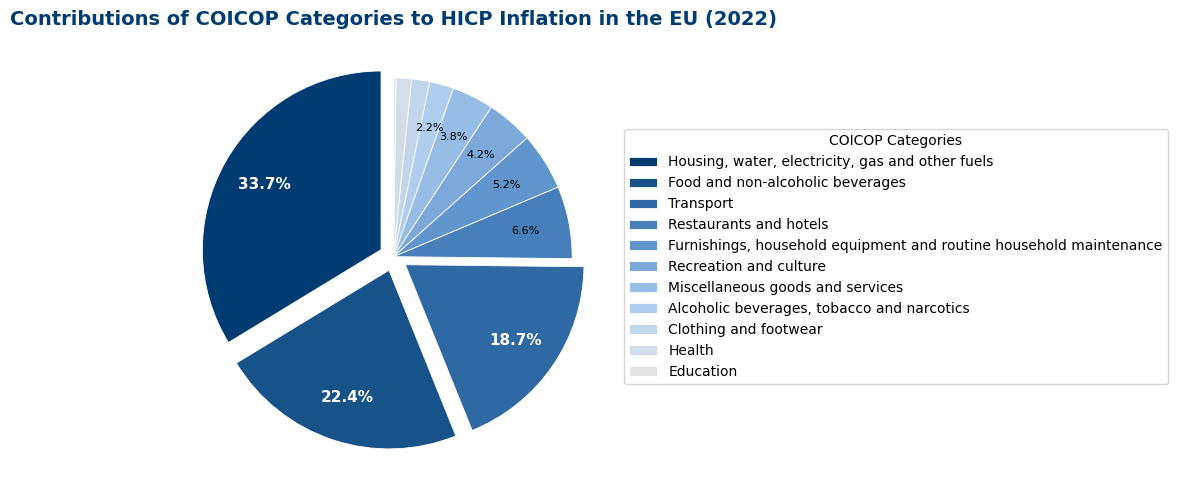

In [4]:

# ---------------------------------------------------
# 1) COICOP weights for EU27 in 2022
# ---------------------------------------------------

# Here I start from the weights dataset, keep only EU27 in 2022,
# and rename the old column 'HICP' to  'weight', since in this file HICP stores category weights.
eu27_weights_2022 = (
    df_weights
    .assign(year=lambda d: d['Date'].dt.year)
    .query("Country == 'European Union - 27 countries (from 2020)' and year == 2022")
    .rename(columns={'HICP': 'weight'})
)

# Check of the total_weight
total_weight = eu27_weights_2022['weight'].sum()
print(total_weight)  

# Convert raw weights into shares of the consumption basket
eu27_weights_2022['weight_share'] = eu27_weights_2022['weight'] / total_weight


# ---------------------------------------------------
# 2) Average 2022 inflation by COICOP category (EU27)
# ---------------------------------------------------

# Here I compute the average YoY inflation in 2022 for each COICOP category,
# excluding the all-items aggregate, and focusing on EU27.
eu27_inflation_by_category_2022 = (
    df_all
    .query("label != 'All-items HICP' and Country == 'European Union - 27 countries (from 2020)'")
    .sort_values(['Country', 'label', 'Date'])
    .assign(year=lambda d: d['Date'].dt.year)
    .query("year == 2022")
    .groupby('label', as_index=False)['inflation_yoy']
    .mean()
)

# I then merge the category-level inflation data with the corresponding
# COICOP basket weights (expressed as shares).
eu27_inflation_by_category_2022 = eu27_inflation_by_category_2022.merge(
    eu27_weights_2022[['label', 'weight_share']],
    on='label',
    how='left'
)


# ---------------------------------------------------
# 3) Compute contributions to total inflation
# ---------------------------------------------------

# Contribution in percentage points for each category:
# contribution_i = weight_share_i * inflation_i
eu27_inflation_by_category_2022['contribution_pp'] = (
    eu27_inflation_by_category_2022['weight_share']
    * eu27_inflation_by_category_2022['inflation_yoy']
)

# Reconstruct total average inflation in 2022 from the sum of contributions
total_inflation_2022 = eu27_inflation_by_category_2022['contribution_pp'].sum()
print("Average inflation in 2022 (reconstructed):", total_inflation_2022)

# Share of each category in total inflation
eu27_inflation_by_category_2022['share'] = (
    eu27_inflation_by_category_2022['contribution_pp'] / total_inflation_2022
)

# Sort categories by their contribution share for plotting
eu27_inflation_by_category_2022 = (
    eu27_inflation_by_category_2022
    .sort_values('share', ascending=False)
    .reset_index(drop=True)
)


# ---------------------------------------------------
# 4) Prepare data for the pie chart
# ---------------------------------------------------

# For the pie chart, I only keep categories with a positive contribution.
positive_contributions = eu27_inflation_by_category_2022[
    eu27_inflation_by_category_2022['contribution_pp'] > 0
]

sorted_contributions = positive_contributions.sort_values("share", ascending=False)
labels = sorted_contributions["label"]
sizes  = sorted_contributions["share"].to_numpy()
n = len(sizes)


# ---------------------------------------------------
# 5) Color set up for the chart
# ---------------------------------------------------

anchors = ["#003C71", "#4F87C4", "#A9CBEF", "#E5E5E5"]
cmap = LinearSegmentedColormap.from_list("corp_blue_grey", anchors)
colors_list = [to_hex(cmap(x)) for x in np.linspace(0, 1, n)]

# I slightly "explode" the top 3 categories to highlight their contribution.
explode = [0.08 if i < 3 else 0 for i in range(n)]


# ---------------------------------------------------
# 6) Plot the pie chart
# ---------------------------------------------------

fig, ax = plt.subplots(figsize=(14, 5))

wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    colors=colors_list,
    startangle=90,
    # I only display a percentage label if the slice is larger than 2%,
    # to avoid cluttering the figure.
    autopct=lambda p: f"{p:.1f}%" if p > 2 else "",
    pctdistance=0.75,
    wedgeprops=dict(linewidth=0.6, edgecolor="white")
)


# ---------------------------------------------------
# 7) Style the percentage labels
# ---------------------------------------------------

# For readability, I use white, bold text for the top 3 (dark) slices,
# and smaller black labels for the remaining categories.
for i, at in enumerate(autotexts):
    if i < 3:
        at.set_color("white")
        at.set_fontweight("bold")
        at.set_fontsize(11)
    else:
        at.set_color("black")
        at.set_fontsize(8)


# ---------------------------------------------------
# 8) Legend and title
# ---------------------------------------------------

ax.legend(
    wedges, labels,
    title="COICOP Categories",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

ax.set_title(
    "Contributions of COICOP Categories to HICP Inflation in the EU (2022)",
    fontsize=14,
    color="#003C71",
    fontweight="bold",
    loc="center"
)

plt.tight_layout()
plt.show()


## III.3.	Intra-category analysis of price components

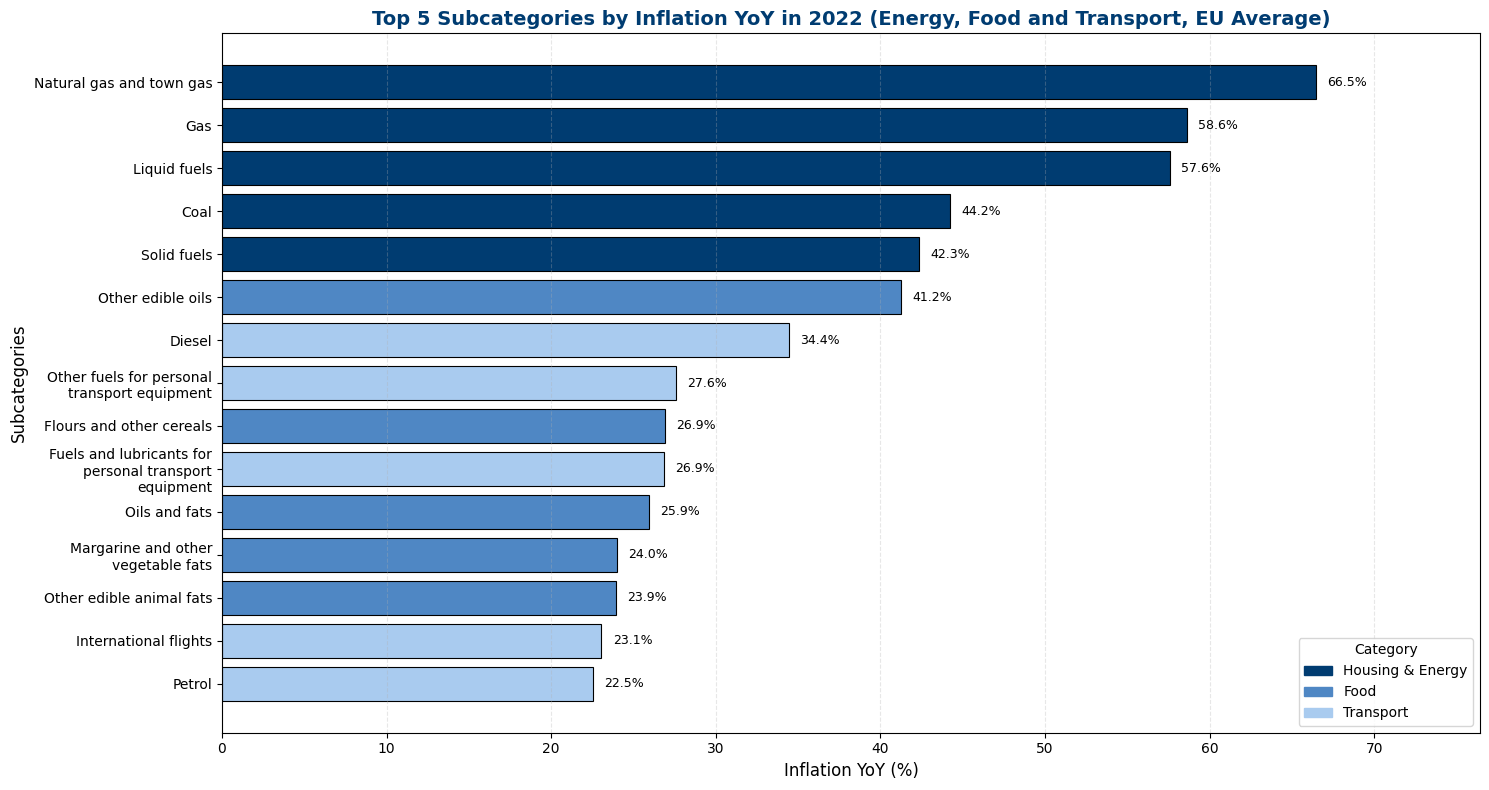

In [5]:
# ---------------------------------------------------
# 1) Prepare the dataset: filter, compute YoY inflation, keep top subcategories
# ---------------------------------------------------

# Start from the full COICOP dataset, remove the three headline categories
# (we want only their subcomponents), compute YoY inflation for 2022,
# and extract the top 5 subcategories per main category.

subcat_inflation_2022 = (
    df_all_items
    .query(
        "HICP != 0 "
        "and label != 'Food and non-alcoholic beverages' "
        "and label != 'Transport' "
        "and label != 'Housing & Energy' "
        "and label != 'Electricity, gas and other fuels'"
    )
    .assign(
        year=lambda d: d['Date'].dt.year,
        inflation_yoy=lambda d: d.groupby(['Country', 'label'])['HICP']
                                  .pct_change(periods=12) * 100
    )
    .query("year == 2022")
    .groupby(['Category', 'label'])
    .agg({'inflation_yoy': 'mean'})
    # Rank subcategories within each main category and keep the top 5
    .assign(rank=lambda d: d.groupby('Category')['inflation_yoy']
                             .rank(ascending=False, method='dense'))
    .query("rank <= 5")
    .reset_index()
)

# Sort ascending for a clean horizontal bar chart
df_plot = subcat_inflation_2022.sort_values("inflation_yoy", ascending=True).copy()

# Wrap long labels so they don't overflow on the y-axis
df_plot["label_wrapped"] = df_plot["label"].apply(
    lambda x: "\n".join(textwrap.wrap(x, 25))
)

# ---------------------------------------------------
# 2) palette for the three main categories
# ---------------------------------------------------

color_map = {
    "Housing & Energy": "#003C71",  # deep corporate blue
    "Food": "#4F87C4",              # medium corporate blue
    "Transport": "#A9CBEF"          # light corporate blue
}

df_plot["color"] = df_plot["Category"].map(color_map)

# ---------------------------------------------------
# 3) Horizontal bar chart
# ---------------------------------------------------

fig, ax = plt.subplots(figsize=(15, 8))

bars = ax.barh(
    df_plot["label_wrapped"],
    df_plot["inflation_yoy"],
    color=df_plot["color"],
    edgecolor="black",
    linewidth=0.8
)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 0.7,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.1f}%",
        va="center",
        ha="left",
        fontsize=9
    )

# ---------------------------------------------------
# 4) Title, labels, grid, and limits
# ---------------------------------------------------

ax.set_title(
    "Top 5 Subcategories by Inflation YoY in 2022 (Energy, Food and Transport, EU Average)",
    fontsize=14,
    fontweight="bold",
    color="#003C71"
)

ax.set_xlabel("Inflation YoY (%)", fontsize=12)
ax.set_ylabel("Subcategories", fontsize=12)

ax.grid(axis="x", linestyle="--", alpha=0.3)
ax.set_xlim(0, df_plot["inflation_yoy"].max() * 1.15)

# ---------------------------------------------------
# 5) Legend
# ---------------------------------------------------

legend_handles = [
    mpatches.Patch(color=color_map["Housing & Energy"], label="Housing & Energy"),
    mpatches.Patch(color=color_map["Food"], label="Food"),
    mpatches.Patch(color=color_map["Transport"], label="Transport")
]

ax.legend(handles=legend_handles, title="Category", loc="lower right")

plt.tight_layout()
plt.show()


# IV.	Structural Analysis of Country Differences

## IV.1. Cross-country comparison of inflation rates in 2022

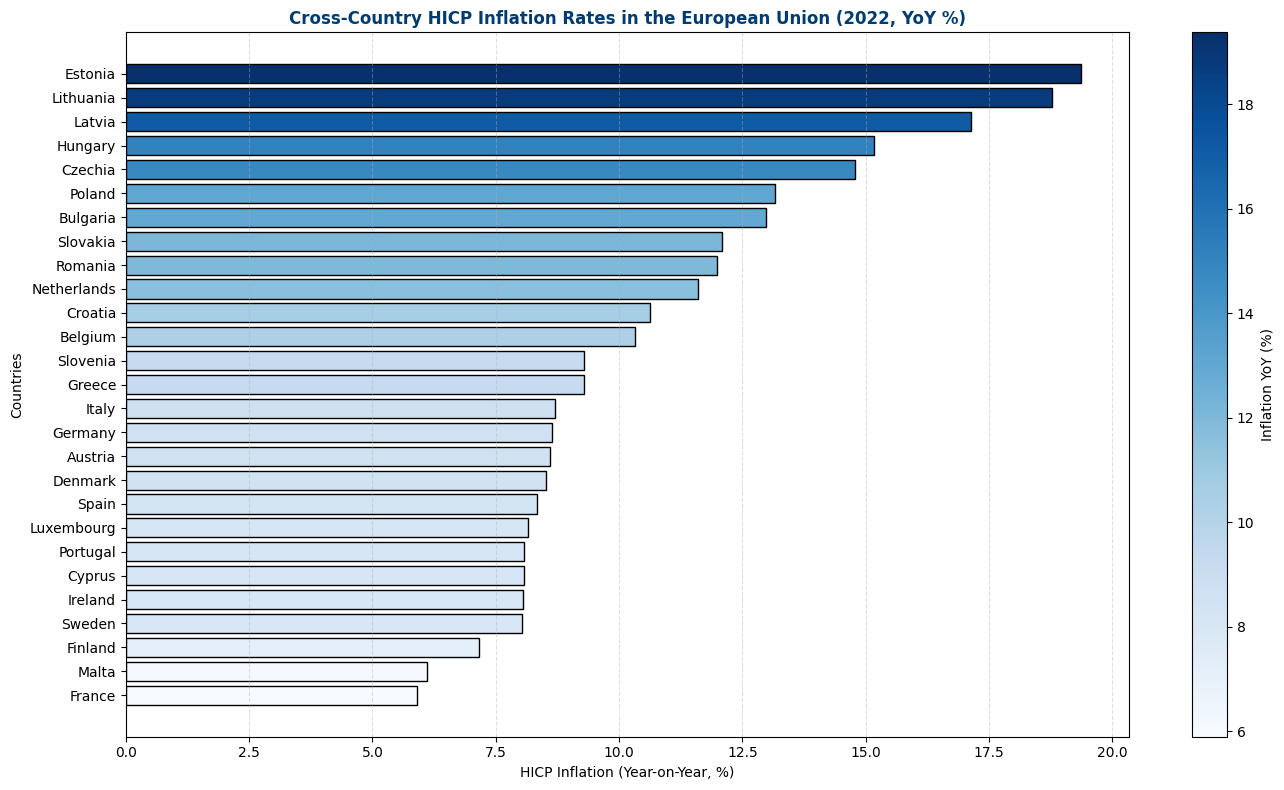

In [6]:
# 1. Data Preparation
# I filter the dataset to focus on 2022, excluding the EU aggregate to keep only individual countries.
# Since the data is monthly, I group by country and compute the mean to get the average annual inflation.
df_inflation_2022 = (df_all
      .assign(Year = lambda y : y['Date'].dt.year)
      .query("label == 'All-items HICP' and Year == 2022 and Country != 'European Union - 27 countries (from 2020)'")
      .groupby(['Country', 'Year'], as_index=False)['inflation_yoy']
      .mean()
      # I also add a ranking and a 'regime' category (Moderate/High/Extreme) for analytical context.
      .assign( 
          rank=lambda r : r['inflation_yoy'].rank(ascending=False, method='dense'), 
          inflation_regime = lambda ir: pd.cut(ir['inflation_yoy'], bins=[0, 10, 15, 20], labels=['Moderate', 'High', 'Extreme'])
      )
)

# 2. Plotting Setup
# Sort the countries by inflation rate (lowest to highest) to make the chart easier to read.
df_sorted = df_inflation_2022.sort_values('inflation_yoy')
inflation_values = df_sorted['inflation_yoy'].values
countries = df_sorted['Country']

# Initialize figure
fig, ax = plt.subplots(figsize=(14,8))

# dynamic Color Mapping
# I map the color intensity to the inflation value: darker blue indicates higher inflation.
norm = Normalize(vmin=inflation_values.min(), vmax=inflation_values.max())
cmap = plt.cm.Blues  
colors = cmap(norm(inflation_values))

# Create a ScalarMappable object strictly for the colorbar generation later.
sm = ScalarMappable(norm=norm, cmap=cmap)

# 3. Generate the Chart
# Plot horizontal bars with the mapped colors.
bars = ax.barh(countries, inflation_values, color=colors, edgecolor='black')

# Add the colorbar to provide a visual reference scale.
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Inflation YoY (%)")

# 4. Final Styling
# Add a light grid for readability and proper labels.
ax.grid(True, axis='x', linestyle='--', alpha=0.4)
ax.set_xlabel("HICP Inflation (Year-on-Year, %)")
ax.set_ylabel("Countries")
plt.title("Cross-Country HICP Inflation Rates in the European Union (2022, YoY %)", color='#003C71', fontweight='bold')

plt.tight_layout()
plt.show()

## IV.2.	Country-level structural inflation profiles

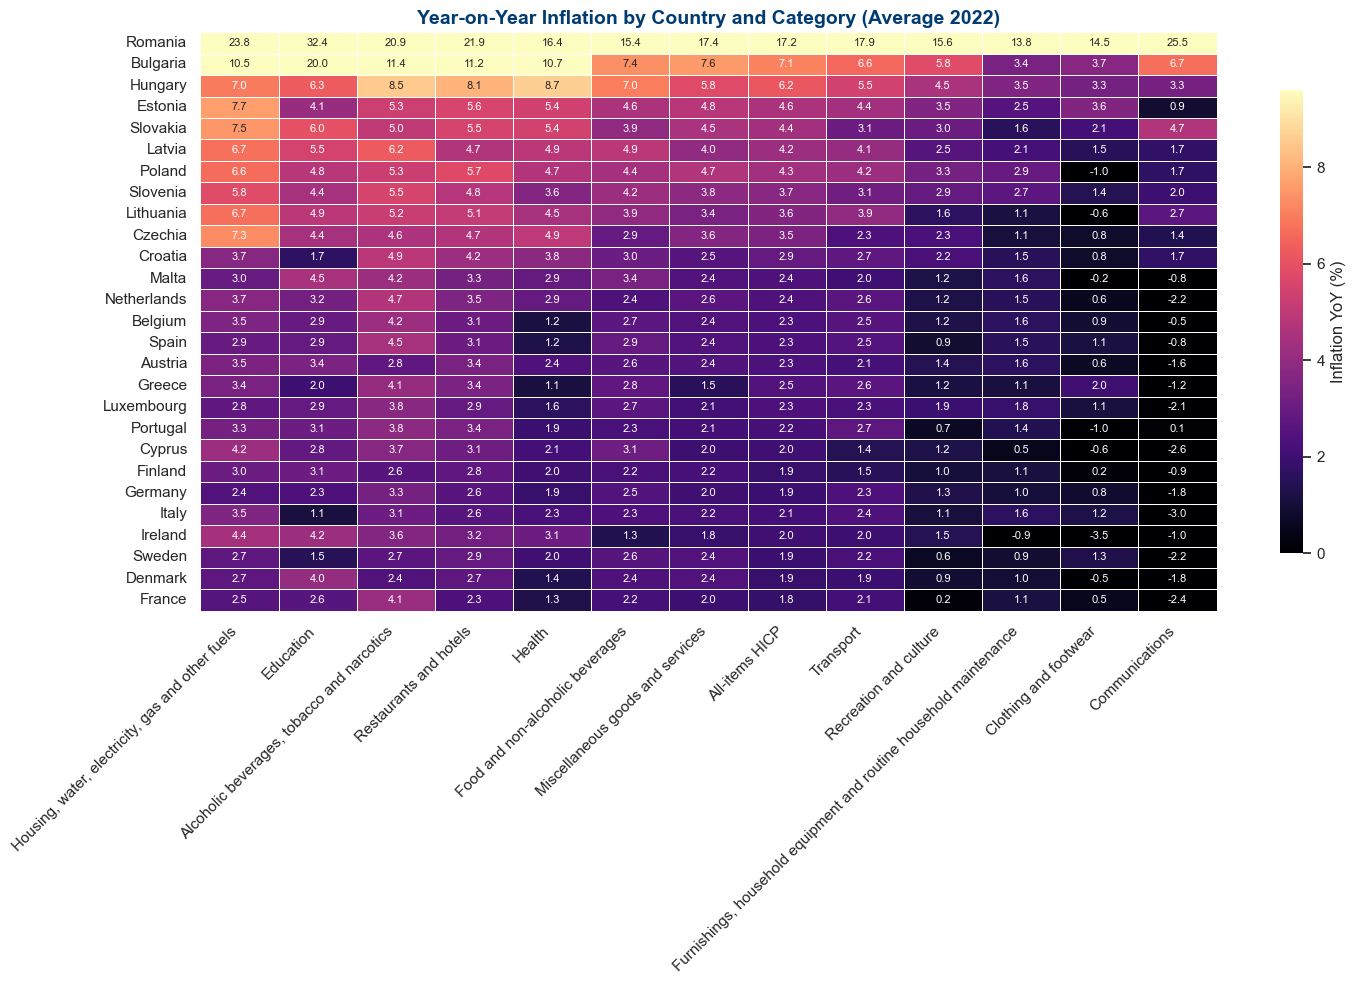

In [7]:
import seaborn as sn

# Pivot the data so that:
# rows are countries
# columns are COICOP categories
# cell values are average YoY inflation

pivot_args = {
    'index': 'Country',
    'columns': 'label',
    'values': 'inflation_yoy',
    'aggfunc': 'mean'
}

df_filtered = df_all.query("Country != 'European Union - 27 countries (from 2020)'")
inflation_pivot = df_filtered.pivot_table(**pivot_args)

# Set a Seaborn theme for nicer default styling
sn.set_theme(style="white", context="notebook")

# Reorder countries and categories by their average inflation:
# countries with the highest average inflation appear at the top,
# and categories with the highest average inflation appear on the left.
row_order = inflation_pivot.mean(axis=1).sort_values(ascending=False).index
col_order = inflation_pivot.mean(axis=0).sort_values(ascending=False).index

inflation_heatmap_data = inflation_pivot.reindex(index=row_order, columns=col_order)

# To avoid a few extreme values dominating the color scale,
# cap the colormap maximum at the 95th percentile of the data.
vmin = max(0, inflation_heatmap_data.min().min())
vmax = min(30, inflation_heatmap_data.stack().quantile(0.95))

fig, ax = plt.subplots(figsize=(15, 10))

sn.heatmap(
    inflation_heatmap_data,
    ax=ax,
    cmap="magma",
    vmin=vmin,
    vmax=vmax,
    annot=True,
    fmt=".1f",
    annot_kws={"fontsize": 8},
    linewidths=0.6,
    linecolor="white",
    cbar_kws={"label": "Inflation YoY (%)", "shrink": 0.8}
)

ax.set_title(
    "Year-on-Year Inflation by Country and Category (Average 2022)",
    fontsize=14,
    color='#003C71',
    fontweight='bold'
)

# Axis labels are left blank to keep the focus on country/category names
ax.set_xlabel("")
ax.set_ylabel("")

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


## IV.3. PCA analysis of inflation structure and category correlations

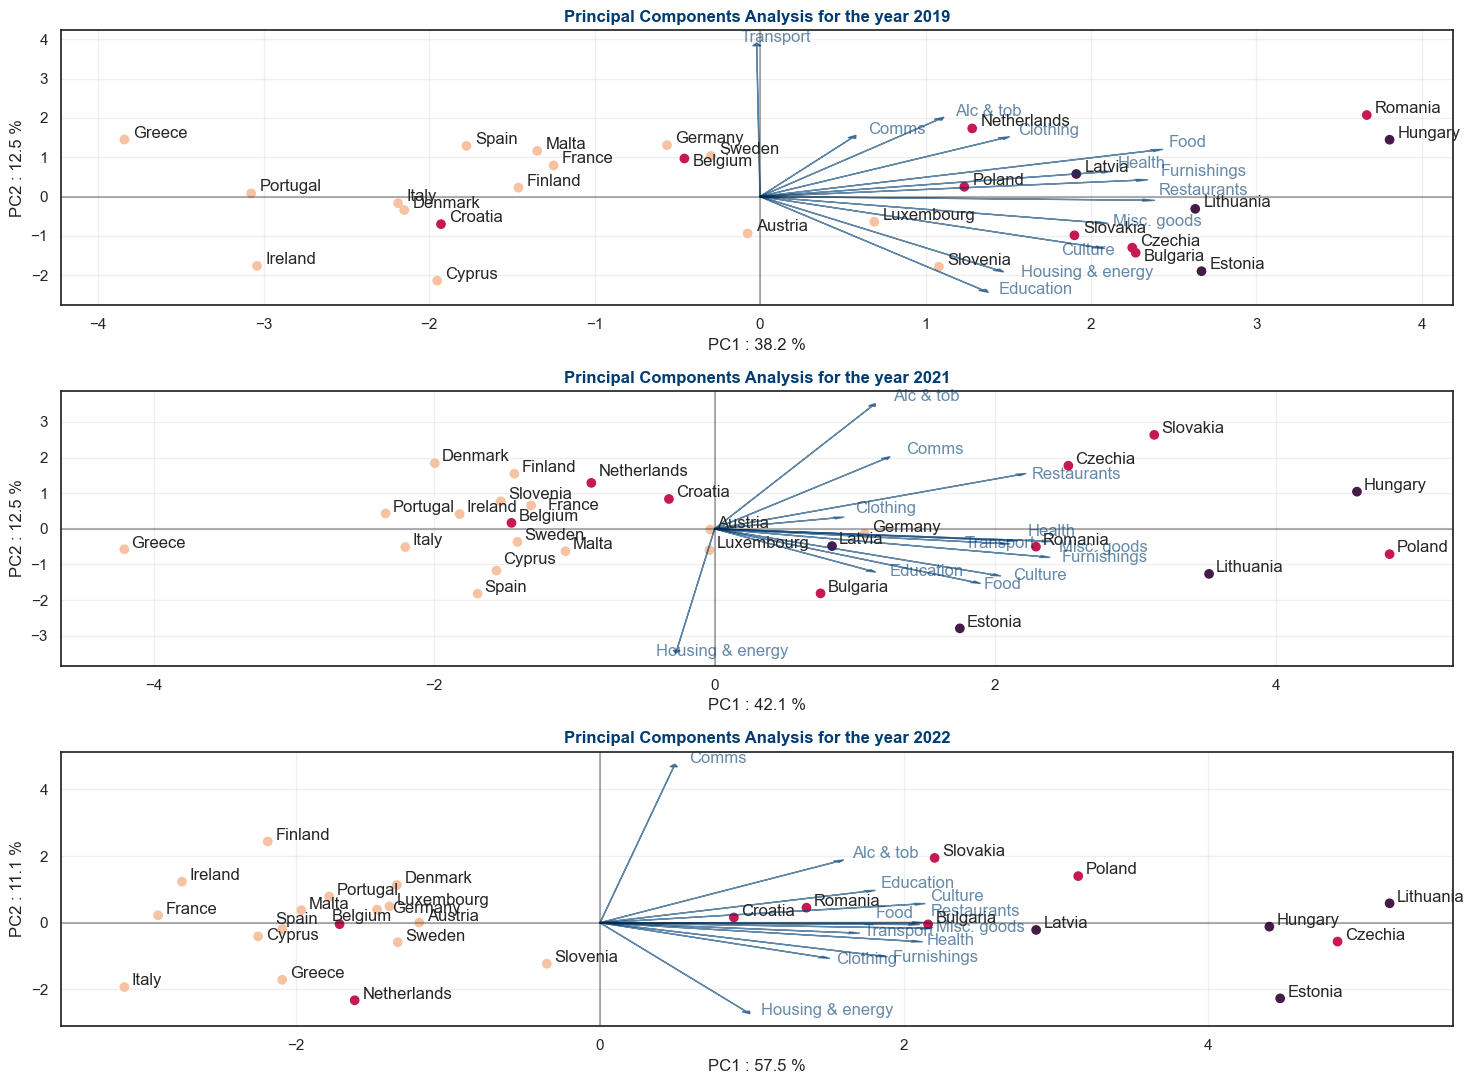

In [8]:


# Define a custom color map for consistency with previous charts
hicp_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "hicp_blue",
    ["#E5E5F0", "#A9CBEF", "#4F87C4", "#003C71"]
)

# =============================================================================
# Step 1: Data Preparation for PCA
# =============================================================================

# To conduct the PCA, we first need to isolate the inflation data for the specific 
# years of interest: 2019 (pre-crisis), 2021 (onset), and 2022 (peak).

# Calculate the Year attribute from the Date column
df_pca = (
    df_all
    .assign(Year = lambda y : y.Date.dt.year)
    .dropna()
)

# Create three separate dataframes for each period.
# We explicitly exclude the EU aggregate to focus on country-level granularity.

df_pca_2019 = (
    df_pca
    .query("Year == 2019 and Country != 'European Union - 27 countries (from 2020)'")
    .groupby(['Country', 'label'], as_index=False)
    .agg({'inflation_yoy':'mean'})
)

df_pca_2021 = (
    df_pca
    .query("Year == 2021 and Country != 'European Union - 27 countries (from 2020)'")
    .groupby(['Country', 'label'], as_index=False)
    .agg({'inflation_yoy':'mean'})
)

df_pca_2022 = (
    df_pca
    .query("Year == 2022 and Country != 'European Union - 27 countries (from 2020)'")
    .groupby(['Country', 'label'], as_index=False)
    .agg({'inflation_yoy':'mean'})
)

# =============================================================================
# Step 2: PCA Computation and Visualization
# =============================================================================

# Group the datasets and define the target years for the loop
annual_datasets = [df_pca_2019, df_pca_2021, df_pca_2022]
target_years = [2019, 2021, 2022]

# Initialize the figure with 3 subplots (one per year)
fig, ax = plt.subplots(len(annual_datasets), 1, figsize=(15, 11))

# Pivot parameters used to reshape the data from Long to Wide format
pivot_args = {
    'index': 'Country',
    'columns': 'label',
    'values': 'inflation_yoy',
    'aggfunc': 'mean'
}

# Mapping dictionary to shorten category names for cleaner chart labels
category_labels_map = {
    "All-items HICP": "All",
    "Food and non-alcoholic beverages": "Food",
    "Alcoholic beverages, tobacco and narcotics": "Alc & tob",
    "Clothing and footwear": "Clothing",
    "Housing, water, electricity, gas and other fuels": "Housing & energy",
    "Furnishings, household equipment and routine household maintenance": "Furnishings",
    "Health": "Health",
    "Transport": "Transport",
    "Communications": "Comms",
    "Recreation and culture": "Culture",
    "Education": "Education",
    "Restaurants and hotels": "Restaurants",
    "Miscellaneous goods and services": "Misc. goods",
}

# Lists to store results for potential future comparisons
all_loadings = []
all_pca_results = []

# Define color clusters based on 2022 inflation intensity.
# This helps visually track how high-inflation countries (in 2022) were positioned in previous years.
df_cluster_colors = df_pca_2022.query("label == 'All-items HICP'").copy()
df_cluster_colors['Cluster'] = pd.cut(
    df_cluster_colors['inflation_yoy'], 
    bins=[0, 10, 15, 20], 
    labels=['Moderate', 'High', 'Very High']
)
df_cluster_colors['Color'] = df_cluster_colors['Cluster'].apply(
    lambda x: np.where(x == 'Moderate', "#f7c2a2", np.where(x == 'High', "#c71951", "#451c47"))
)

# Loop through each year to compute PCA and plot the results
for i, dataframe in enumerate(annual_datasets):

    # Extract aggregate inflation for merging later
    dataframe_all_items = dataframe.query("label == 'All-items HICP'")

    # Reshape the dataframe: Observations = Countries, Features = Categories.
    # We exclude the 'All-items' category from the features to avoid collinearity issues.
    df_pivot = (dataframe
                .query("label != 'All-items HICP'")
                .pivot_table(**pivot_args))

    values = df_pivot
    country_labels = df_pivot.index.unique()

    # Standardize the features (mean=0, variance=1) before applying PCA
    values_normalized = StandardScaler().fit_transform(values)

    # Compute PCA
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(values_normalized)

    # Extract explained variance and loadings (vectors)
    explained_var = pca.explained_variance_ratio_.round(3)
    loadings = pca.components_.T

    # Store Loadings in a clean DataFrame
    df_loadings = pd.DataFrame(data=loadings, columns=['PC1', 'PC2', 'PC3'])
    df_loadings['labels'] = df_pivot.columns.unique()
    df_loadings['labels'] = df_loadings['labels'].replace(category_labels_map)

    # Store PCA scores (coordinates of countries) in a clean DataFrame
    df_pca_final = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
    df_pca_final['Country'] = country_labels

    # Merge back the actual inflation values for reference
    inflation_per_country = df_pca_final.merge(dataframe_all_items, on='Country', how='left')['inflation_yoy']

    # Archive results
    all_loadings.append(df_loadings)
    all_pca_results.append(df_pca_final)

    # -------------------------------------------------------------------------
    # Visualization: Scatter Plot of Countries
    # -------------------------------------------------------------------------
    
    ax[i].scatter(
        df_pca_final['PC1'],
        df_pca_final['PC2'],
        color=df_cluster_colors['Color'] # Apply the consistent color mapping defined earlier
    )

    # Manual adjustment of country labels.
    # To ensure the chart is readable, we apply specific offsets (dx, dy) to countries
    # that would otherwise overlap on the plot.
    for j, _ in enumerate(df_pca_final.index):
        
        country_name = df_pca_final.iloc[j, 3]
        
        # Default offset
        dx, dy = 0.05, 0.05
        if i == 0:
            if country_name in ['Bulgaria', 'Belgium']:
                dy = -0.2

        elif i == 1: # Adjustments for 2021
            if country_name == 'France':
                dx, dy = 0.12, -0.12
            elif country_name in ['Netherlands', 'Cyprus']:
                dx, dy = 0.05, 0.2
        
        elif i == 2: # Adjustments for 2022
            if country_name == 'Germany':
                dx, dy = 0.1, -0.11
            elif country_name == 'Cyprus':
                dx, dy = 0.05, -0.1
            elif country_name == 'Spain':
                dx, dy = -0.05, 0.14
            elif country_name == 'Belgium':
                dx, dy = -0.05, 0.1

        # Annotate the country
        ax[i].text(
            x = df_pca_final.iloc[j, 0] + dx,
            y = df_pca_final.iloc[j, 1] + dy,
            s = country_name
        )

    # -------------------------------------------------------------------------
    # Visualization: Feature Vectors (Loadings)
    # -------------------------------------------------------------------------
    
    scale = 6 # Scaling factor to make vectors visible relative to the scatter plot

    for k, _ in enumerate(df_loadings.index):
        
        feature_label = df_loadings.iloc[k, 3]
        
        # Similar to countries, we manually adjust the position of feature labels
        # to prevent overlapping vectors, which is common in PCA biplots.
        
        # Default offset based on vector direction
        delta_x = 0.1 if df_loadings.iloc[k, 0] > 0 else -0.1
        delta_y = 0.1 if df_loadings.iloc[k, 1] > 0 else -0.1

        if i == 0: # 2019 Adjustments
            if feature_label == "Furnishings":
                delta_x = 0.15 if df_loadings.iloc[k, 0] > 0 else -0.15
                delta_y = 0.1
            elif feature_label == "Housing & energy":
                delta_x = 0.15 if df_loadings.iloc[k, 0] > 0 else -0.2
                delta_y = -0.2
            elif feature_label == 'Culture':
                delta_x, delta_y = -0.2, -0.2
            elif feature_label == 'Restaurants':
                delta_y = 0.12

        elif i == 1: # 2021 Adjustments
            if feature_label == "Food":
                delta_x, delta_y = 0.08, -0.2
            elif feature_label == "Health":
                delta_x = 0.15 if df_loadings.iloc[k, 0] > 0 else -0.15
                delta_y = 0.13
            elif feature_label == "Misc. goods":
                delta_x, delta_y = 0.12, -0.3
            elif feature_label == "Transport":
                delta_x, delta_y = -0.25, -0.12
            elif feature_label == 'Restaurants':
                delta_y = -0.12
            else:
                # Slight generic tweak for 2021
                delta_x = 0.15 if df_loadings.iloc[k, 0] > 0 else -0.15
                delta_y = 0.15 if df_loadings.iloc[k, 1] > 0 else -0.15

        else: # 2022 Adjustments
            if feature_label == "Restaurants":
                delta_x, delta_y = 0.12, 0.2
            elif feature_label in ["Clothing", "Furnishings"]:
                delta_x, delta_y = 0.1, -0.2
            elif feature_label == "Food":
                delta_x, delta_y = -0.22, 0.2

        # Draw the vector arrow
        ax[i].arrow(
            x=0, y=0,
            dx = df_loadings.iloc[k, 0] * scale,
            dy = df_loadings.iloc[k, 1] * scale,
            head_width = 0.05,
            color = '#003C71',
            alpha = 0.6
        )

        # Place the feature label
        ax[i].text(
            x = df_loadings.iloc[k, 0] * scale + delta_x,
            y = df_loadings.iloc[k, 1] * scale + delta_y,
            s = feature_label,
            color = '#003C71',
            alpha = 0.6
        )

    # -------------------------------------------------------------------------
    # Final Chart formatting
    # -------------------------------------------------------------------------

    # Add origin lines for reference
    ax[i].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax[i].axvline(x=0, color='black', linestyle='-', alpha=0.3)

    # Label axes with the percentage of variance explained
    ax[i].set_xlabel(f"PC1 : {explained_var[0]*100:.1f} %")
    ax[i].set_ylabel(f"PC2 : {explained_var[1]*100:.1f} %")

    ax[i].set_title(f"Principal Components Analysis for the year {target_years[i]}", color='#003C71', fontweight='bold', loc='center')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()